# Random Testing and Trials with EDA... 

In [1]:
# Imports 
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style='whitegrid')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/healthcare-survey/Data_dictionary.txt
/kaggle/input/healthcare-survey/health_dataset.csv


In [2]:
# Dataset Overview 
df = pd.read_csv('/kaggle/input/healthcare-survey/health_dataset.csv');
df = df.drop(columns=['ADM_RNO1']) # ID col, not useful
df.columns = [col.replace(" ", "") for col in df.columns]
df = df.rename(columns={'weekly_alcohol':'Weekly_alcohol', 'working_status':'Working_status'})
print(df.dtypes)
print(df.shape)

Province                        int64
Health_region_grouped           int64
Gender                          int64
Marital_status                  int64
Household                       int64
Age                             int64
Worked_job_business             int64
Edu_level                       int64
Gen_health_state                int64
Life_satisfaction               int64
Mental_health_state             int64
Stress_level                    int64
Work_stress                     int64
Sense_belonging                 int64
Weight_state                    int64
BMI_12_17                       int64
BMI_18_above                    int64
Sleep_apnea                     int64
High_BP                         int64
High_cholestrol                 int64
Diabetic                        int64
Fatigue_syndrome                int64
Mood_disorder                   int64
Anxiety_disorder                int64
Respiratory_chronic_con         int64
Musculoskeletal_con             int64
Cardiovascul

In [3]:
# Check for Missing Data 
print('------ Percent Missing Data > 0 -----')
missing = 100 * df.isnull().sum() / df.shape[0]
print(missing[missing > 0])

------ Percent Missing Data > 0 -----
Smoked    0.101615
dtype: float64


In [4]:
# Handle Missing Data 
# Drop rows in this case since very few missing
df = df.dropna()
print(df.shape)

(108142, 49)


In [5]:
# Check Unique Values for Columns
pd.Series({col:df[col].unique() for col in df})

Province                           [47, 59, 13, 46, 35, 12, 24, 10, 48, 11, 60]
Health_region_grouped         [47906, 59914, 13904, 46903, 35934, 35933, 129...
Gender                                                                   [2, 1]
Marital_status                                                     [1, 2, 6, 9]
Household                                                             [2, 1, 9]
Age                                                             [3, 5, 4, 2, 1]
Worked_job_business                                          [1, 6, 2, 9, 8, 7]
Edu_level                                                          [3, 2, 1, 9]
Gen_health_state                                          [3, 2, 5, 1, 4, 7, 8]
Life_satisfaction                [9, 4, 7, 8, 0, 10, 6, 5, 99, 3, 2, 97, 98, 1]
Mental_health_state                                    [3, 5, 2, 1, 4, 9, 7, 8]
Stress_level                                              [2, 3, 4, 1, 5, 7, 8]
Work_stress                             

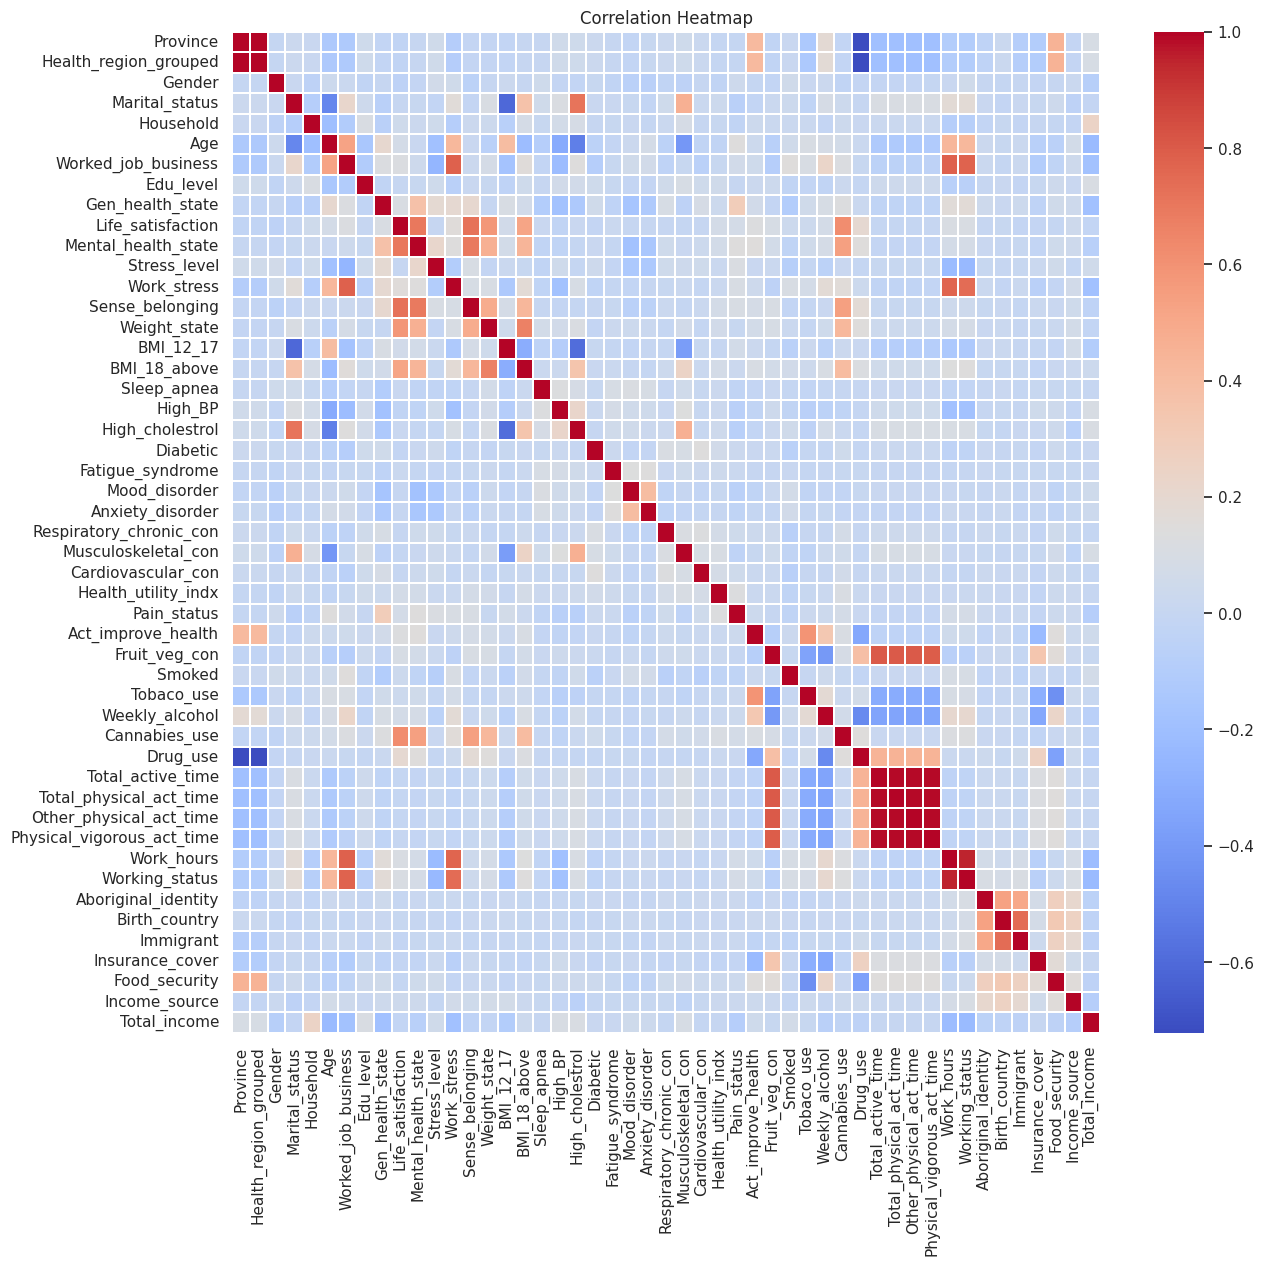

In [6]:
# Plot Correlation of Columns
def plt_corr_heatmap(df):
    plt.figure(figsize=(14,13))
    sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.2)
    plt.title("Correlation Heatmap")
    plt.show()

plt_corr_heatmap(df)

In [7]:
# Drop cols with strong correlation
def drop_strong_corr(df, threshold=0.95):
    corr = df.corr().abs()
    upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df = df.drop(columns=to_drop)
    return df

df = drop_strong_corr(df)
print(df.shape)

(108142, 44)


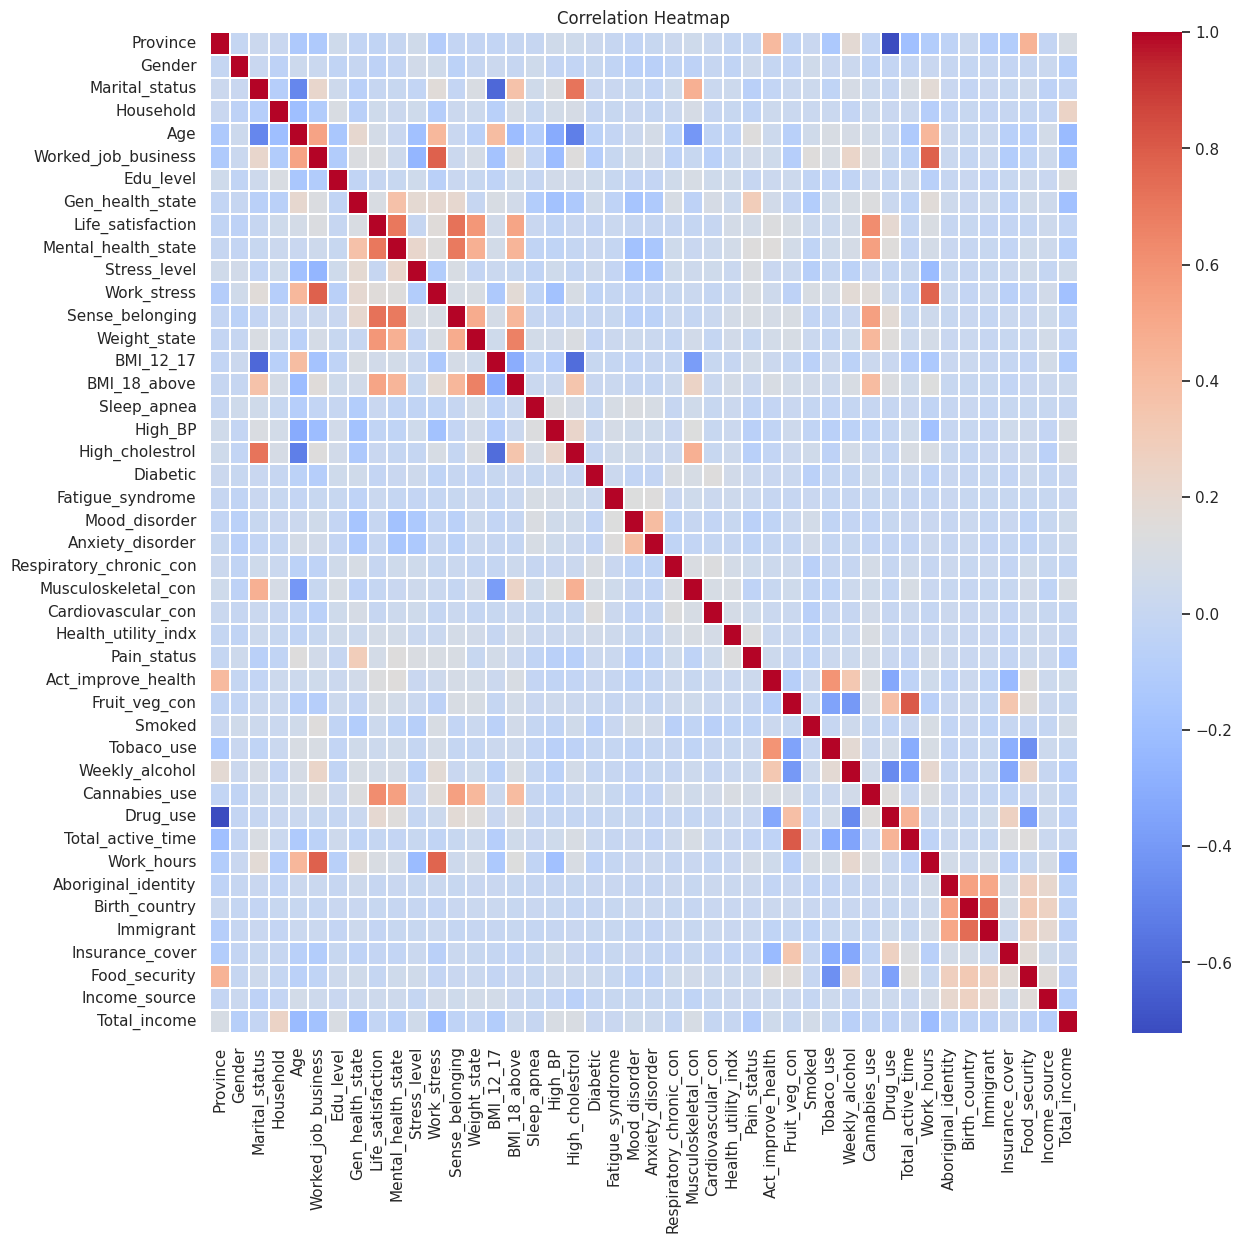

In [8]:
plt_corr_heatmap(df)

In [9]:
# Pie plot for value distribution of columns with less than [threshold] unique values
def plot_pie(df, threshold=15, cols_per_row=5):
    pie_cols = [col for col in df if len(df[col].unique()) < threshold]
    num_plots = len(pie_cols)
 
    rows = math.ceil(num_plots / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(pie_cols):
        df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('')

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# plot_pie(df)

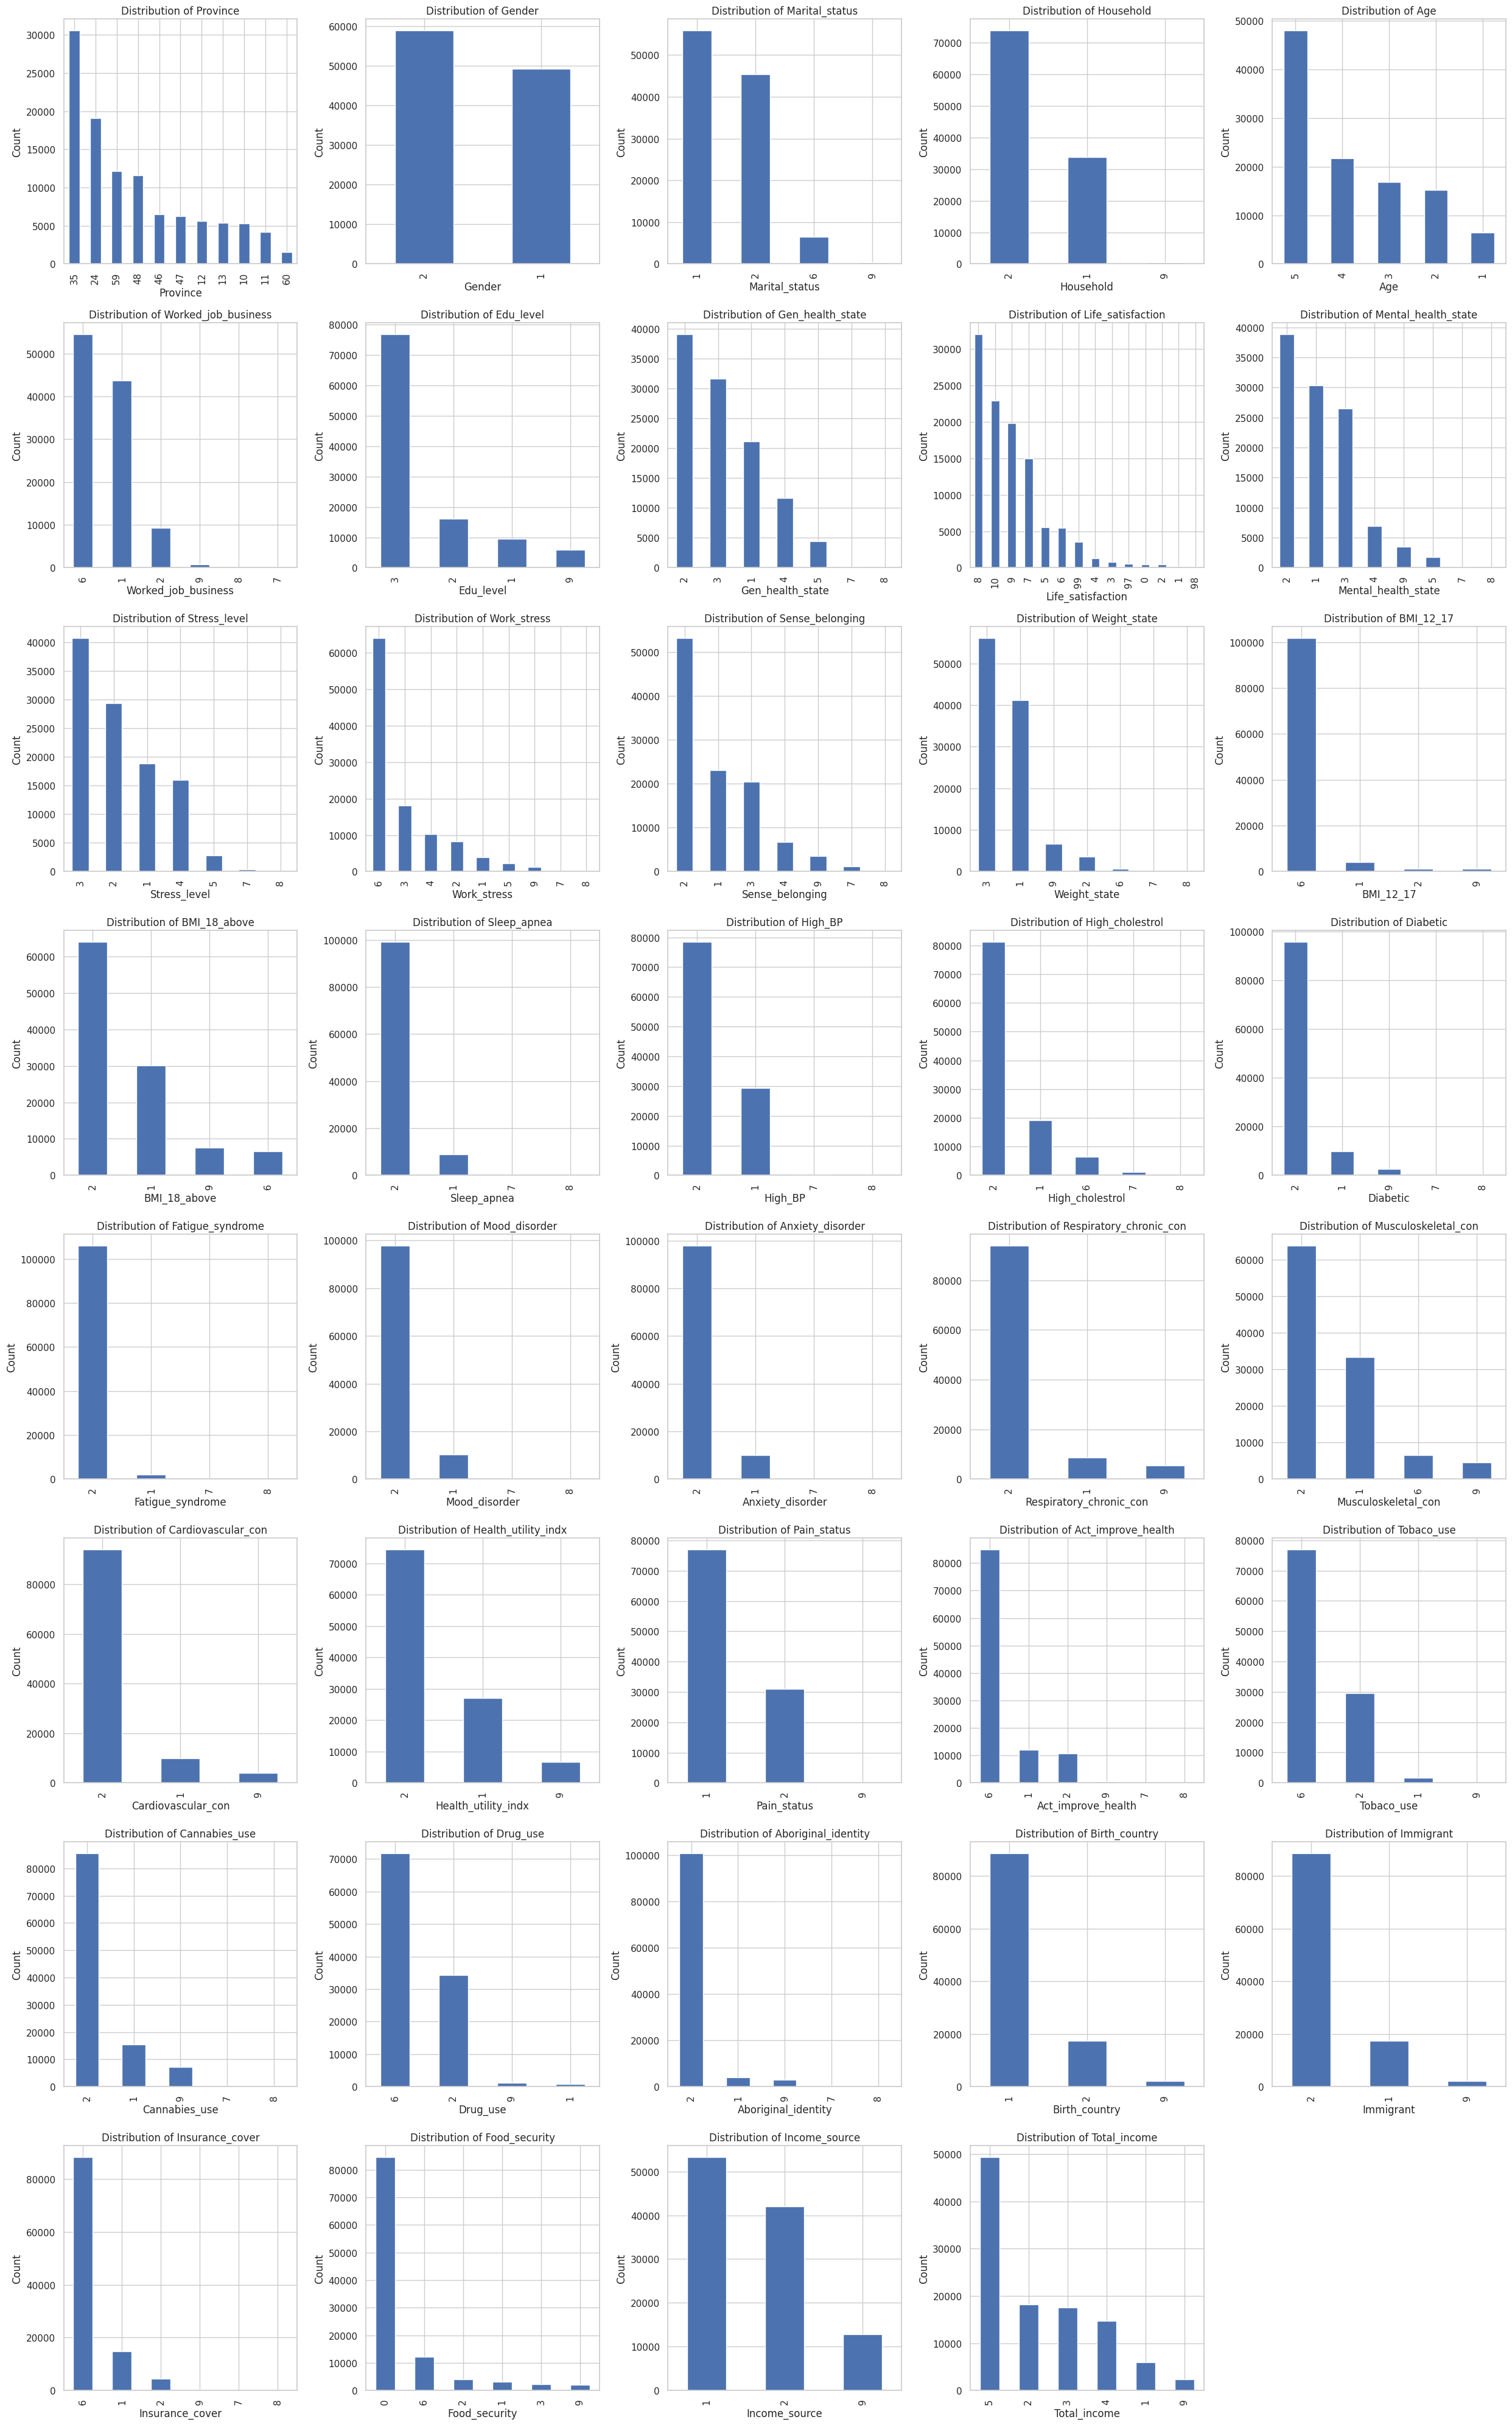

In [10]:
# Histogram plots for columns with less than [threshold] unique values
def plot_hist(df, threshold=15, cols_per_row=5):
    hist_cols = [col for col in df if len(df[col].unique()) < threshold]
    num_plots = len(hist_cols)
    
    rows = math.ceil(num_plots / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(hist_cols):
        df[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_hist(df)

In [11]:
# drop rows where data is less than [threshold]% of the data
def drop_rare_rows(df, threshold=0.000001):
    df_filtered = df.copy() 
    for col in df_filtered.columns:
        counts = df_filtered[col].value_counts(normalize=True)  # Get normalized counts
        rare_values = counts[counts < threshold].index  # Find rare values
        df_filtered = df_filtered[~df_filtered[col].isin(rare_values)]  # Drop rows with rare values
    return df_filtered  

# df_filtered = drop_rare_rows(df)
# print(df_filtered.shape)

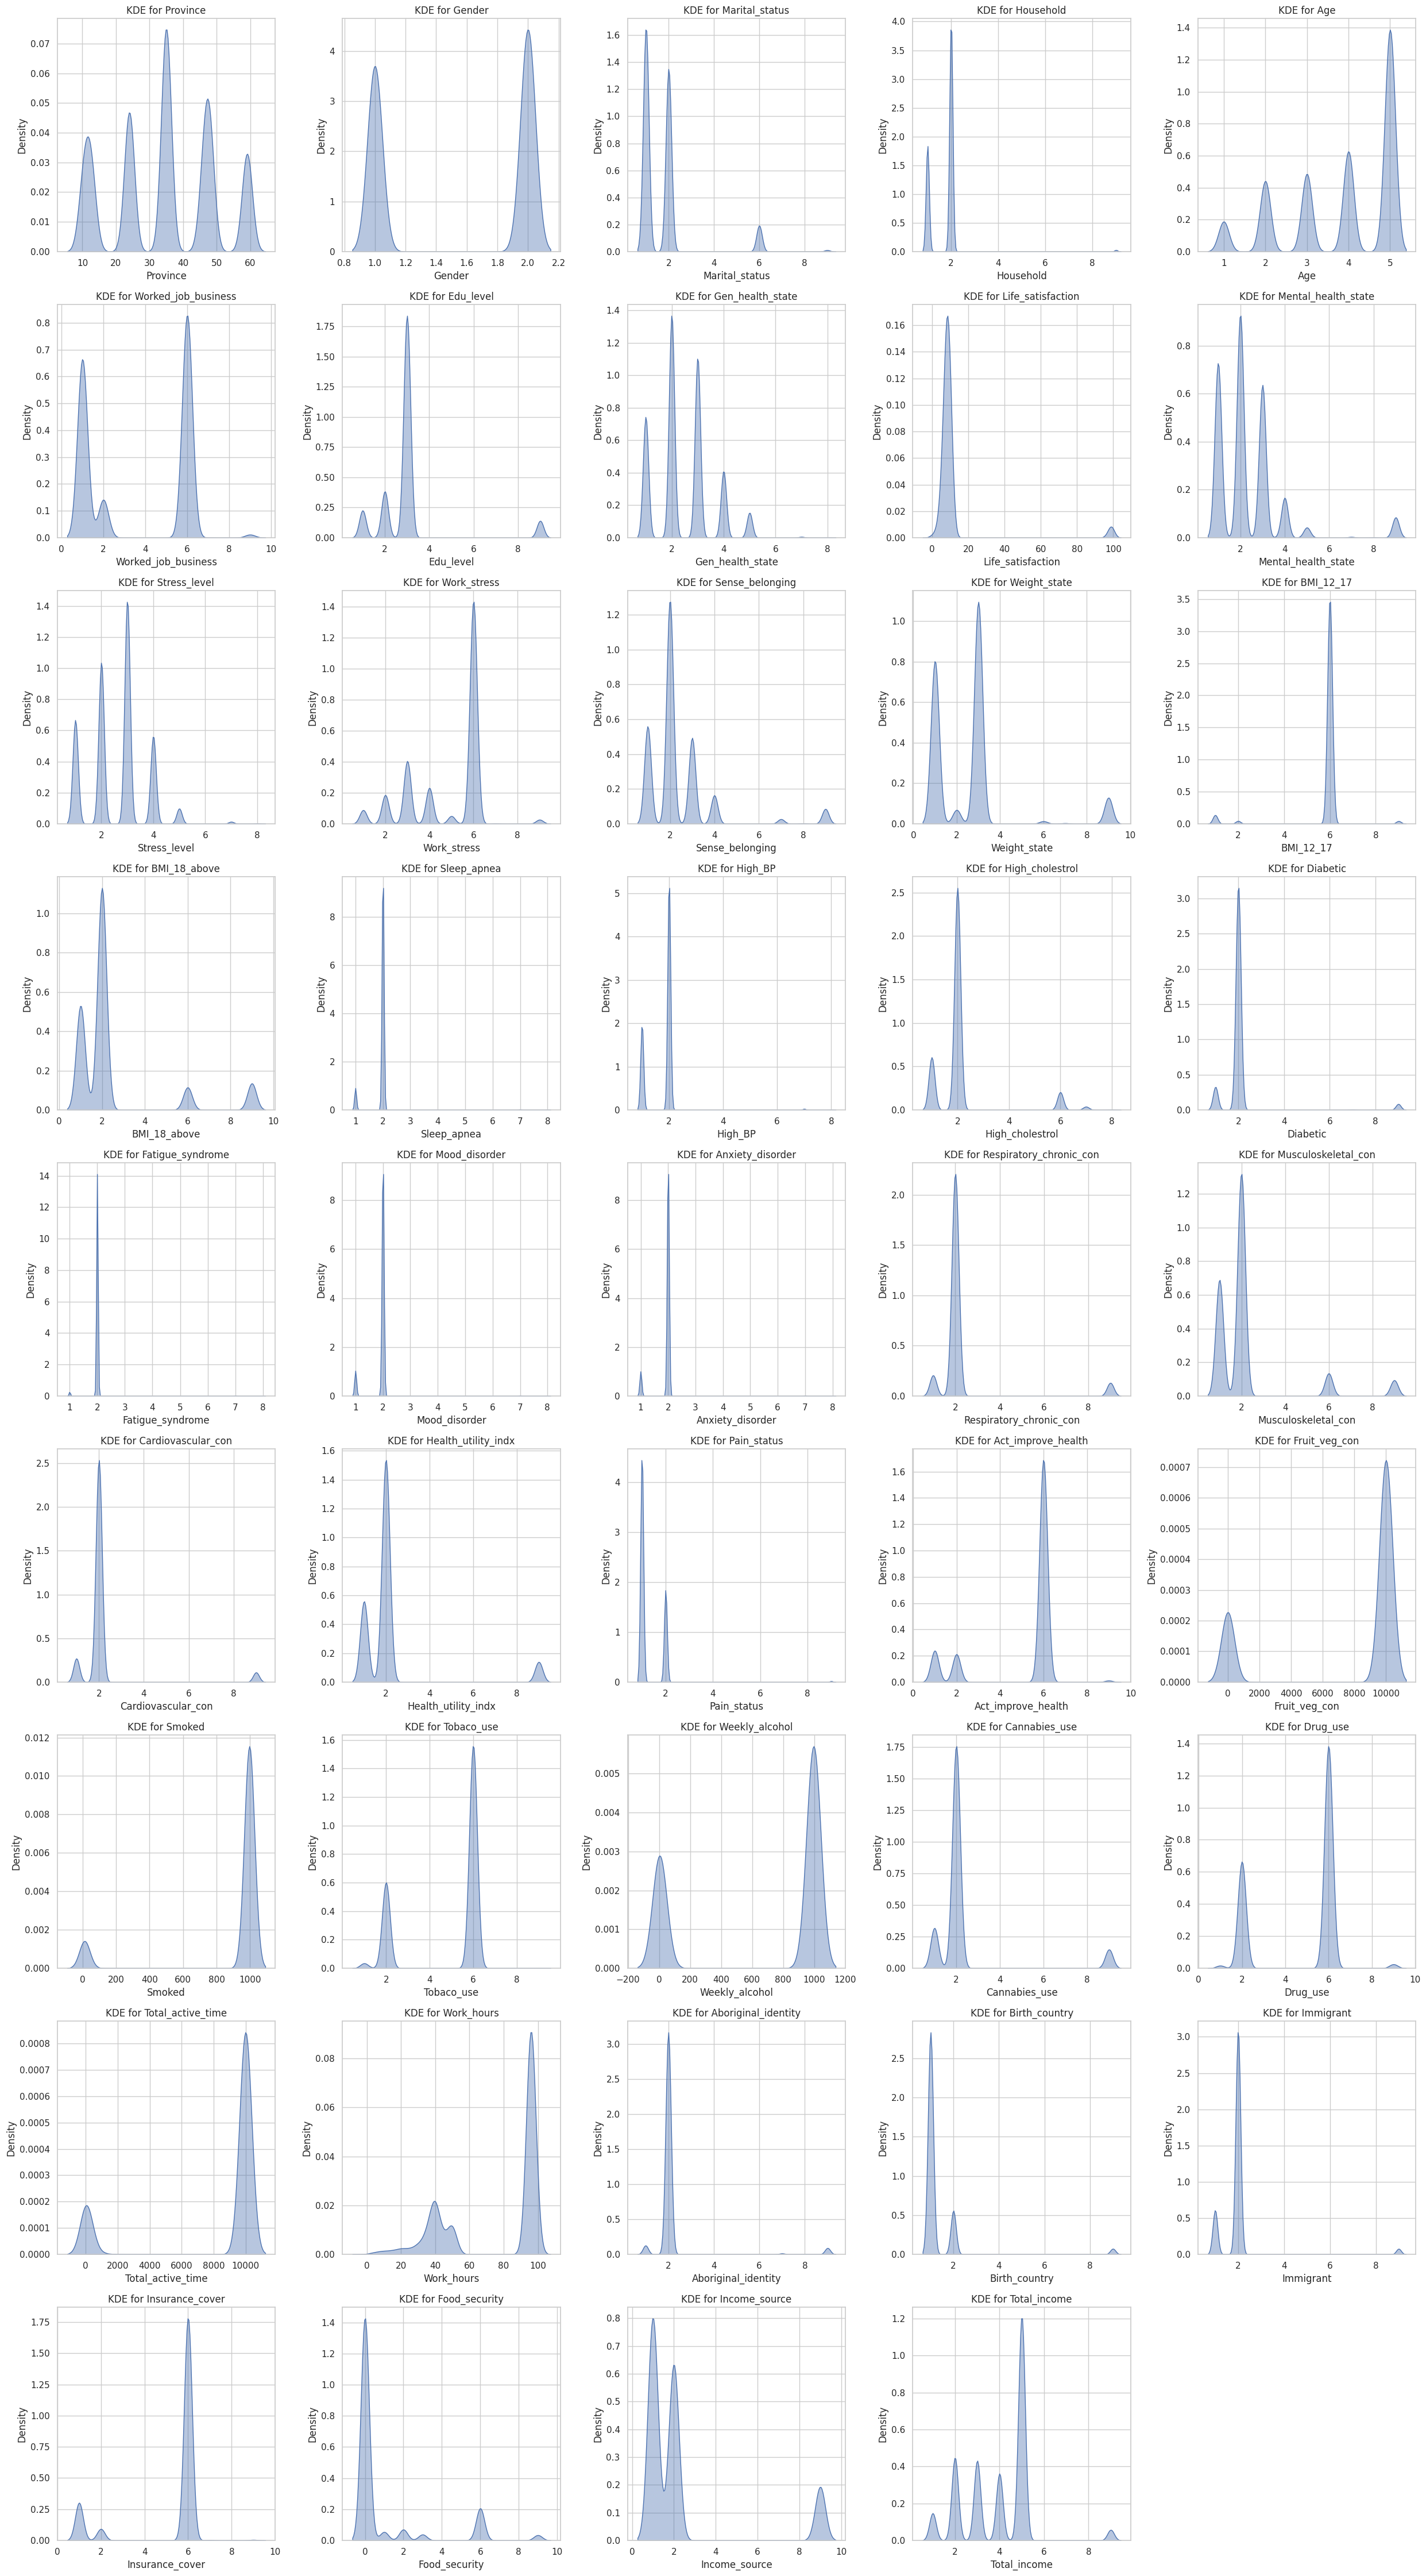

In [12]:
def kde_plot(df, cols_per_row=5):
    num_cols = df.select_dtypes(include=['number']).columns  # Select only numerical columns
    if len(num_cols) == 0: return

    rows = math.ceil(len(num_cols) / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(num_cols):
        sns.kdeplot(df[col], fill=True, alpha=0.4, ax=axes[i])  # Specify axis
        axes[i].set_title(f'KDE for {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


kde_plot(df)

In [13]:
# Print unique values and counts for each col
def print_unique_count(df, threshold=20):
    for col in df.columns:
        unique_values = df[col].nunique()  
        print(f"{col:20s} {unique_values} unique with bounds [{df[col].min()}, {df[col].max()}]") 

        if unique_values < threshold: print(df[col].value_counts(), "\n")

print_unique_count(df)

Province             11 unique with bounds [10, 60]
Province
35    30553
24    19105
59    12167
48    11611
46     6461
47     6225
12     5644
13     5376
10     5329
11     4150
60     1521
Name: count, dtype: int64 

Gender               2 unique with bounds [1, 2]
Gender
2    58914
1    49228
Name: count, dtype: int64 

Marital_status       4 unique with bounds [1, 9]
Marital_status
1    55820
2    45451
6     6497
9      374
Name: count, dtype: int64 

Household            3 unique with bounds [1, 9]
Household
2    73779
1    33843
9      520
Name: count, dtype: int64 

Age                  5 unique with bounds [1, 5]
Age
5    47929
4    21663
3    16800
2    15253
1     6497
Name: count, dtype: int64 

Worked_job_business  6 unique with bounds [1, 9]
Worked_job_business
6    54426
1    43648
2     9281
9      757
8       17
7       13
Name: count, dtype: int64 

Edu_level            4 unique with bounds [1, 9]
Edu_level
3    76780
2    16057
1     9455
9     5850
Name: count, dt

In [14]:
# Correction to Life_satisfaction values
df['Life_satisfaction'] = df['Life_satisfaction'].replace({99:10, 98:10, 97:10})
print(df['Life_satisfaction'].value_counts())

Life_satisfaction
8     31988
10    27133
9     19817
7     15003
5      5558
6      5423
4      1295
3       782
0       464
2       454
1       225
Name: count, dtype: int64


-----Fruit_veg_con------


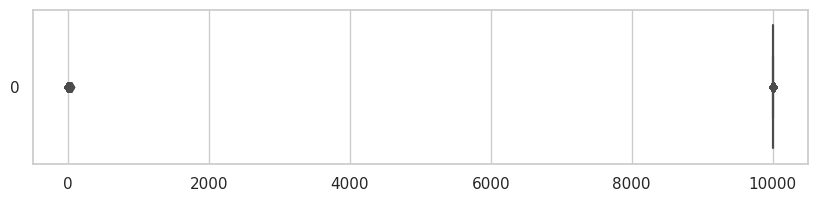

Min: 0.00 | Max: 9999.90 | Mean: 7604.99 | Median: 9999.60
10th quartile: 3.10 | 90th quartile: 9999.60
Percentage < q1: 0.098 | Percentage > q3: 0.016
-----Smoked------


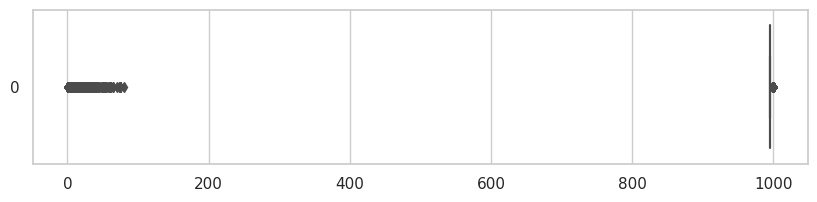

Min: 1.00 | Max: 999.00 | Mean: 885.05 | Median: 996.00
10th quartile: 25.00 | 90th quartile: 996.00
Percentage < q1: 0.095 | Percentage > q3: 0.033
-----Weekly_alcohol------


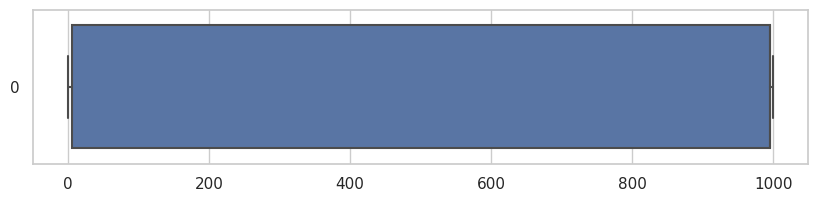

Min: 0.00 | Max: 999.00 | Mean: 659.92 | Median: 996.00
10th quartile: 0.00 | 90th quartile: 996.00
Percentage < q1: 0.000 | Percentage > q3: 0.009
-----Total_active_time------


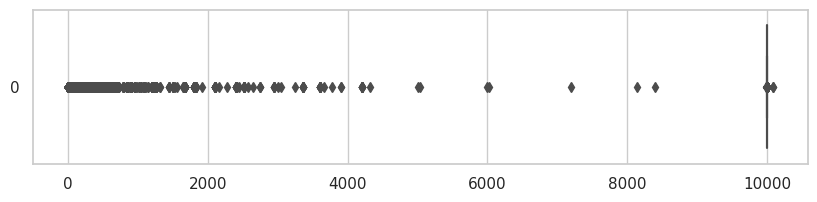

Min: 0.00 | Max: 10080.00 | Mean: 8109.59 | Median: 9996.00
10th quartile: 0.00 | 90th quartile: 9996.00
Percentage < q1: 0.000 | Percentage > q3: 0.002
-----Work_hours------


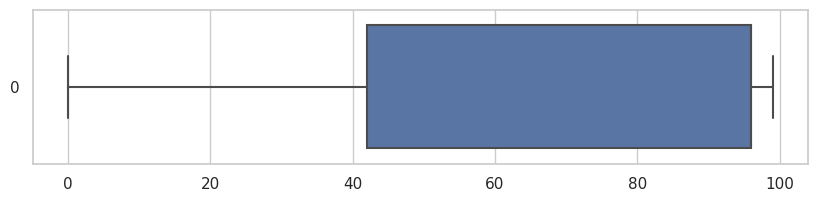

Min: 0.00 | Max: 99.00 | Mean: 75.40 | Median: 96.00
10th quartile: 35.00 | 90th quartile: 96.00
Percentage < q1: 0.071 | Percentage > q3: 0.011


In [15]:
# Get the distribution of cols
def get_distribution(df, cols=df.columns, q1=0.25, q3=0.75):
    for col in cols:
        q1_val, q3_val = df[col].quantile(q1), df[col].quantile(q3)
        print(f"-----{col}------")
        plt.figure(figsize=(10,2))
        sns.boxplot(df[col], orient="h")
        plt.show()
        print(f"Min: {df[col].min():0.2f} | Max: {df[col].max():0.2f} | Mean: {df[col].mean():0.2f} | Median: {df[col].median():0.2f}")
        print(f"{q1*100:1.0f}th quartile: {q1_val:0.2f} | {q3*100:1.0f}th quartile: {q3_val:0.2f}")
        print(f"Percentage < q1: {(df[col] < q1_val).sum()/df[col].size:0.3f} | Percentage > q3: {(df[col] > q3_val).sum()/df[col].size:0.3f}")

cols = [col for col in df.columns if df[col].nunique() >= 20]
get_distribution(df,cols,q1=0.1,q3=0.9)

In [16]:
# Discretize certain cols and apply linear/non-linear transformations to others
df.loc[df['Fruit_veg_con'] < 5000, 'Fruit_veg_con'] = 0
df.loc[df['Fruit_veg_con'] >= 5000, 'Fruit_veg_con'] = 1
df.loc[df['Smoked'] < 500, 'Smoked'] = 0 
df.loc[df['Smoked'] >= 500, 'Smoked'] = 1
df['Fruit_veg_con'] = df['Fruit_veg_con'].astype(int)
df['Smoked'] = df['Smoked'].astype(int)
df['Weekly_alcohol'] = df['Weekly_alcohol']/100
df['Total_active_time'] = np.log1p(df['Total_active_time']).round(2)
df['Work_hours'] = df['Work_hours']/10

In [17]:
# Encoding Data
df = pd.get_dummies(df, columns=["Province","Birth_country","Immigrant"])
df['Gender'] = df['Gender'].replace({1:0, 2:1})

In [18]:
pd.Series({col:df[col].unique() for col in df})

Gender                                                                [1, 0]
Marital_status                                                  [1, 2, 6, 9]
Household                                                          [2, 1, 9]
Age                                                          [3, 5, 4, 2, 1]
Worked_job_business                                       [1, 6, 2, 9, 8, 7]
Edu_level                                                       [3, 2, 1, 9]
Gen_health_state                                       [3, 2, 5, 1, 4, 7, 8]
Life_satisfaction                         [9, 4, 7, 8, 0, 10, 6, 5, 3, 2, 1]
Mental_health_state                                 [3, 5, 2, 1, 4, 9, 7, 8]
Stress_level                                           [2, 3, 4, 1, 5, 7, 8]
Work_stress                                      [2, 6, 4, 3, 7, 1, 5, 9, 8]
Sense_belonging                                        [2, 3, 1, 4, 9, 7, 8]
Weight_state                                           [3, 1, 9, 2, 6, 7, 8]